In [1]:
from CryptoCompareAPI import CryptoCompareAPI
from utils import COIN_LIST, myconcat
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
from arch import arch_model
from random import *
from statsmodels.graphics.tsaplots import plot_acf

## Fetch daily data and calculate daily return

In [3]:
api = CryptoCompareAPI()

param_list = []
for coin in COIN_LIST:
    param_list.append(
        {'fsym':coin, 'tsym':'USD'}
    )

df_list = []
for param in param_list:
    df = api.getCandle('2018-07-20', '2019-07-08', 'd', param=param)
    df_list.append(df)

df = myconcat(df_list, ['time', 'close'])
df.columns = ['time'] + COIN_LIST
df.time = pd.to_datetime(df.time, unit='s')

df = df.iloc[::-1]
df.set_index(['time'], inplace=True)

In [4]:
df['TUSD_ret'] = df['TUSD'].pct_change()

In [9]:
data = df[['TUSD_ret']]

In [11]:
data = data.dropna()

In [12]:
data.head()

,TUSD_ret
time,
2018-07-21,-0.006122
2018-07-22,-0.000404
2018-07-23,0.003334
2018-07-24,0.011881
2018-07-25,-0.014726


## Fetch hourly data and calculate intraday volatility

In [29]:
df_m_list = []
for param in param_list:
    df_m = api.getCandle('2018-07-21', '2019-07-08', 'h', param=param)
    df_m_list.append(df_m)

df_m = myconcat(df_m_list, ['time', 'close'])
df_m.columns = ['time'] + COIN_LIST
df_m.time = pd.to_datetime(df_m.time, unit='s')

df_m = df_m.iloc[::-1]
df_m.set_index(['time'], inplace=True)

In [30]:
df_m.shape

(8449, 7)

In [31]:
df_m.head()

,USDT,DAI,TUSD,GUSD,USDC,PAX,USDS
time,,,,,,,
2018-07-21 00:00:00,0.9991,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-21 01:00:00,0.9992,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-21 02:00:00,0.9995,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-21 03:00:00,0.9993,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-21 04:00:00,1.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_vol = pd.DataFrame()

In [33]:
for coin in COIN_LIST:
    col_name = coin + '_vol'
    crt_time = df.index[0]
    tick_list = [df_m.index[24*i] for i in range(1,352)]
    for tick in tick_list:
        ind_start = tick - timedelta(hours=24)
        ind_end = tick
        df_vol.loc[ind_end-timedelta(hours=24), col_name] = df[coin][ind_start:ind_end].std()*100

In [36]:
data_vol = df_vol[['TUSD_vol']]

In [37]:
data_vol.head()

,TUSD_vol
2018-07-21,0.028284
2018-07-22,0.233345
2018-07-23,0.834386
2018-07-24,1.046518
2018-07-25,0.091924


## Plot daily return ACF and check lags

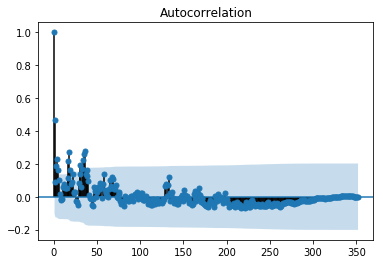

In [38]:
data['squared'] = data['TUSD_ret']**2
plot_acf(data['squared'])
plt.show()

## Use ARCH / GARCH to predict daily volatility

In [54]:
import numpy as np

In [41]:
# split into train/test
n_test = 50
train, test = data['TUSD_ret'][:-n_test], data['TUSD_ret'][-n_test:]

### ARCH(1)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -992.3187221745584
Iteration:      2,   Func. Count:     11,   Neg. LLF: -992.49428800591
Iteration:      3,   Func. Count:     16,   Neg. LLF: -992.794577024737
Iteration:      4,   Func. Count:     22,   Neg. LLF: -992.8355320457483
Iteration:      5,   Func. Count:     28,   Neg. LLF: -992.8419360006319
Iteration:      6,   Func. Count:     32,   Neg. LLF: -992.8421192701228
Iteration:      7,   Func. Count:     36,   Neg. LLF: -992.8421207195768
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -992.8421207195777
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


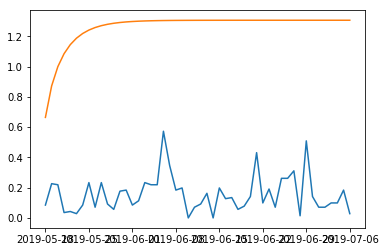

In [57]:
model1 = arch_model(train, mean='Zero', vol='ARCH', p=1)
model1_fit = model1.fit()

data_test1 = data_vol[-n_test:]
yhat1 = model1_fit.forecast(horizon=n_test)
data_test1['TUSD_vol_pred'] = np.sqrt(yhat1.variance.values[-1,:])*100
plt.plot(data_test1)
plt.show()

In [44]:
model1_fit.summary

<bound method ARCHModelResult.summary of                         Zero Mean - ARCH Model Results                        
Dep. Variable:               TUSD_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                       ARCH   Log-Likelihood:                992.842
Distribution:                  Normal   AIC:                          -1981.68
Method:            Maximum Likelihood   BIC:                          -1974.26
                                        No. Observations:                  303
Date:                Wed, Jul 24 2019   Df Residuals:                      301
Time:                        17:58:15   Df Model:                            2
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.3045

### ARCH(4)

In [45]:
model2 = arch_model(train, mean='Zero', vol='ARCH', p=4)
model2_fit = model2.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -976.9514748914636
Iteration:      2,   Func. Count:     15,   Neg. LLF: -984.2443736352038
Iteration:      3,   Func. Count:     23,   Neg. LLF: -988.9904793771689
Iteration:      4,   Func. Count:     33,   Neg. LLF: -989.1176502399787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -989.1176506481702
            Iterations: 8
            Function evaluations: 33
            Gradient evaluations: 4


D:\Anaconda\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


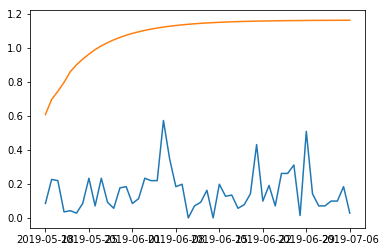

In [58]:
data_test2 = data_vol[-n_test:]
yhat2 = model2_fit.forecast(horizon=n_test)
data_test2['TUSD_vol_pred'] = np.sqrt(yhat2.variance.values[-1,:])*100
plt.plot(data_test2)
plt.show()

In [47]:
model2_fit.summary

<bound method ARCHModelResult.summary of                         Zero Mean - ARCH Model Results                        
Dep. Variable:               TUSD_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                       ARCH   Log-Likelihood:                989.118
Distribution:                  Normal   AIC:                          -1968.24
Method:            Maximum Likelihood   BIC:                          -1949.67
                                        No. Observations:                  303
Date:                Wed, Jul 24 2019   Df Residuals:                      298
Time:                        17:58:27   Df Model:                            5
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2

### GARCH(1,1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: -987.5065032368941
Iteration:      2,   Func. Count:     12,   Neg. LLF: -987.8635484776205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -987.8635473086687
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2


D:\Anaconda\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


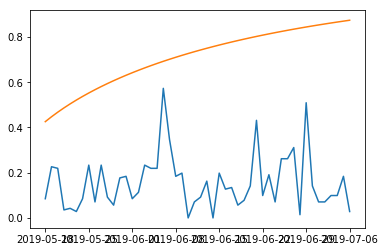

In [59]:
model3 = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
model3_fit = model3.fit()

data_test3 = data_vol[-n_test:]
yhat3 = model3_fit.forecast(horizon=n_test)
data_test3['TUSD_vol_pred'] = np.sqrt(yhat3.variance.values[-1,:])*100
plt.plot(data_test3)
plt.show()

In [49]:
model3_fit.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:               TUSD_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                987.864
Distribution:                  Normal   AIC:                          -1969.73
Method:            Maximum Likelihood   BIC:                          -1958.59
                                        No. Observations:                  303
Date:                Wed, Jul 24 2019   Df Residuals:                      300
Time:                        17:58:39   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.2585

### GARCH(4,4)

Iteration:      1,   Func. Count:     11,   Neg. LLF: -971.7669566337012
Iteration:      2,   Func. Count:     23,   Neg. LLF: -990.7009937239442
Iteration:      3,   Func. Count:     35,   Neg. LLF: -993.444301229852
Iteration:      4,   Func. Count:     49,   Neg. LLF: -993.6528036611728
Iteration:      5,   Func. Count:     70,   Neg. LLF: -993.652812110024
Iteration:      6,   Func. Count:     86,   Neg. LLF: -993.6548045587058
Iteration:      7,   Func. Count:    101,   Neg. LLF: -993.6563642059607
Iteration:      8,   Func. Count:    118,   Neg. LLF: -994.7145568452584
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -994.7145574373739
            Iterations: 12
            Function evaluations: 118
            Gradient evaluations: 8


D:\Anaconda\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


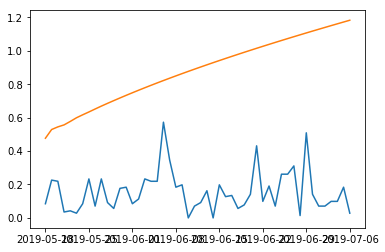

In [62]:
model4 = arch_model(train, mean='Zero', vol='GARCH', p=4, q=4)
model4_fit = model4.fit()

data_test4 = data_vol[-n_test:]
yhat4 = model4_fit.forecast(horizon=n_test)
data_test4['TUSD_vol_pred'] = np.sqrt(yhat4.variance.values[-1,:])*100
plt.plot(data_test4)
plt.show()

In [51]:
model4_fit.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:               TUSD_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                994.715
Distribution:                  Normal   AIC:                          -1971.43
Method:            Maximum Likelihood   BIC:                          -1938.01
                                        No. Observations:                  303
Date:                Wed, Jul 24 2019   Df Residuals:                      294
Time:                        17:58:47   Df Model:                            9
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4852